In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "skin-cancer-data"

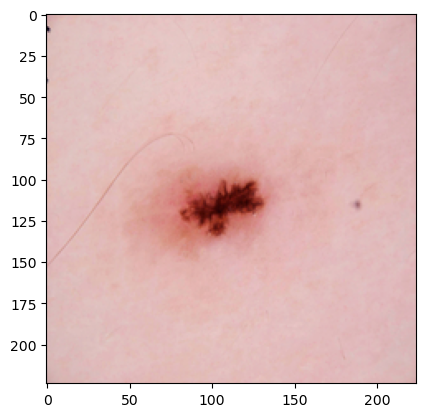

In [3]:
import matplotlib.image as mpimg
test_image = "skin-cancer-data/benign/1.jpg"
img = mpimg.imread(test_image)
plt.imshow(img)

In [4]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3297 files belonging to 2 classes.
Using 2638 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3297 files belonging to 2 classes.
Using 659 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['benign', 'malignant']

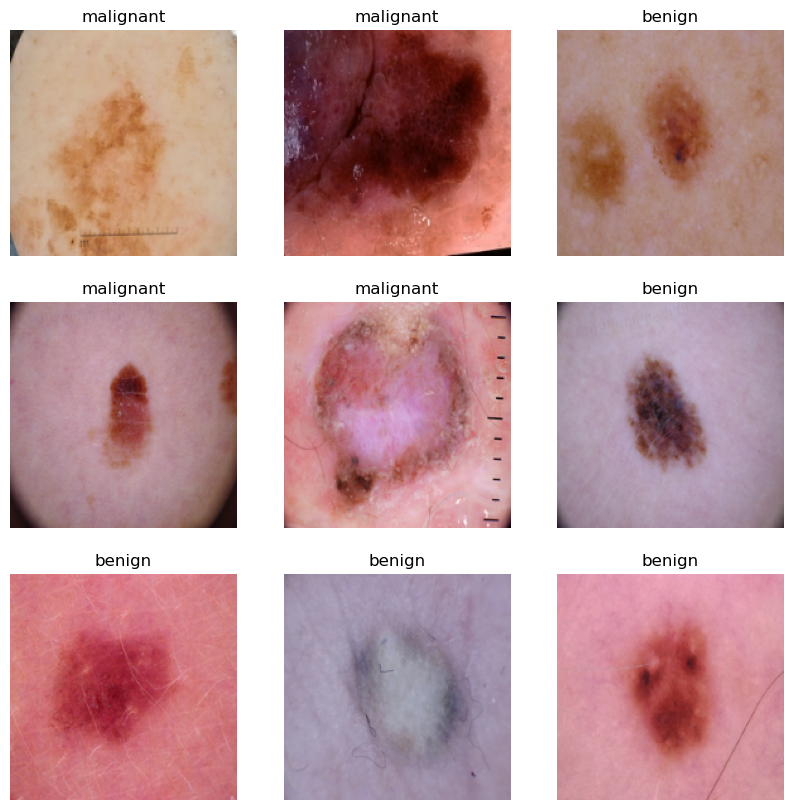

In [8]:
# Here are the first nine images from training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
# manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [10]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Standardize values to be in the [0, 1] RGB channel range by using tf.keras.Rescalling
normalization_layers = layers.Rescaling(1./255)

In [12]:
# create a basic keras model

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [13]:
# Compile the model

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [14]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
# Train the model for 10 epochs

epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
83/83 [==============================] - 124s 1s/step - loss: 0.7133 - accuracy: 0.6459 - val_loss: 0.4904 - val_accuracy: 0.7769
Epoch 2/10
83/83 [==============================] - 91s 1s/step - loss: 0.4865 - accuracy: 0.7612 - val_loss: 0.4552 - val_accuracy: 0.7860
Epoch 3/10
83/83 [==============================] - 88s 1s/step - loss: 0.4388 - accuracy: 0.7862 - val_loss: 0.4532 - val_accuracy: 0.7375
Epoch 4/10
83/83 [==============================] - 88s 1s/step - loss: 0.4052 - accuracy: 0.7942 - val_loss: 0.4654 - val_accuracy: 0.7815
Epoch 5/10
83/83 [==============================] - 87s 1s/step - loss: 0.3698 - accuracy: 0.8241 - val_loss: 0.4473 - val_accuracy: 0.8073
Epoch 6/10
83/83 [==============================] - 87s 1s/step - loss: 0.3597 - accuracy: 0.8366 - val_loss: 0.5365 - val_accuracy: 0.7633
Epoch 7/10
83/83 [==============================] - 87s 1s/step - loss: 0.3449 - accuracy: 0.8245 - val_loss: 0.3726 - val_accuracy: 0.8073
Epoch 8/10
83/83 [=

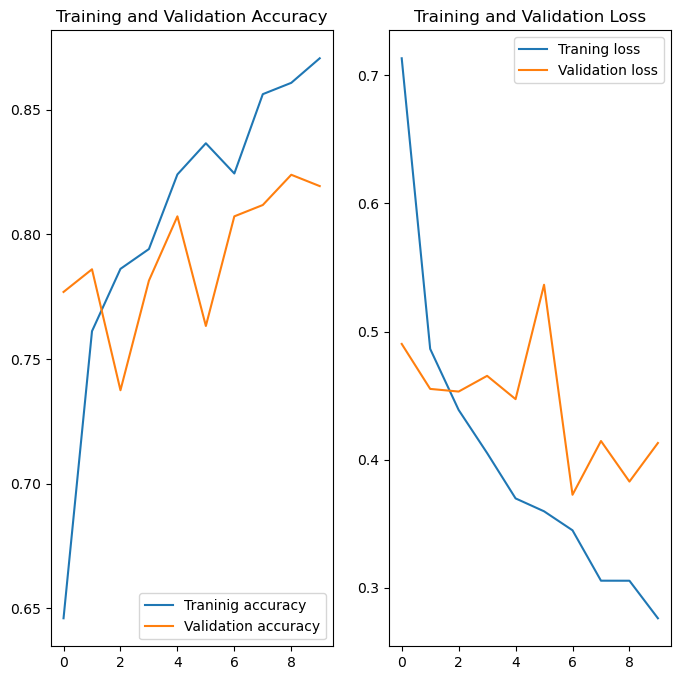

In [16]:
# visualize training results by creatting plots for loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Traninig accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Traning loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [17]:
# Reduce overfitting though data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height, 
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

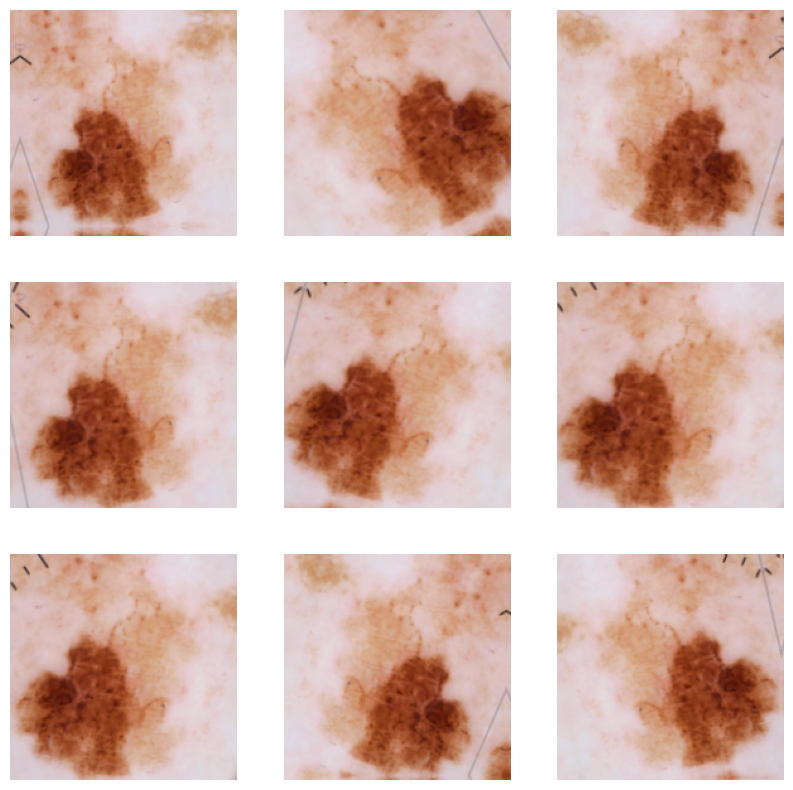

In [18]:
# visualize a few augmentade examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [19]:
# introduce Dropout to the network to help reduce overfitting

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

In [20]:
# compile and train the model

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/15
83/83 [==============================] - 111s 1s/step - loss: 0.6556 - accuracy: 0.6774 - val_loss: 0.4930 - val_accuracy: 0.7618
Epoch 2/15
83/83 [==============================] - 102s 1s/step - loss: 0.4642 - accuracy: 0.7699 - val_loss: 0.4839 - val_accuracy: 0.7739
Epoch 3/15
83/83 [==============================] - 103s 1s/step - loss: 0.4135 - accuracy: 0.7915 - val_loss: 0.4506 - val_accuracy: 0.7936
Epoch 4/15
83/83 [==============================] - 109s 1s/step - loss: 0.3983 - accuracy: 0.8059 - val_loss: 0.4164 - val_accuracy: 0.7891
Epoch 5/15
83/83 [==============================] - 110s 1s/step - loss: 0.3867 - accuracy: 0.8108 - val_loss: 0.4261 - val_accuracy: 0.8012
Epoch 6/15
83/83 [==============================] - 111s 1s/step - loss: 0.3681 - accuracy: 0.8268 - val_loss: 0.3902 - val_accuracy: 0.8073
Epoch 7/15
83/83 [==============================] - 110s 1s/step - loss: 0.3952 - accuracy: 0.8074 - val_loss: 0.4019 - val_accuracy: 0.8088
Epoch 8/15
83

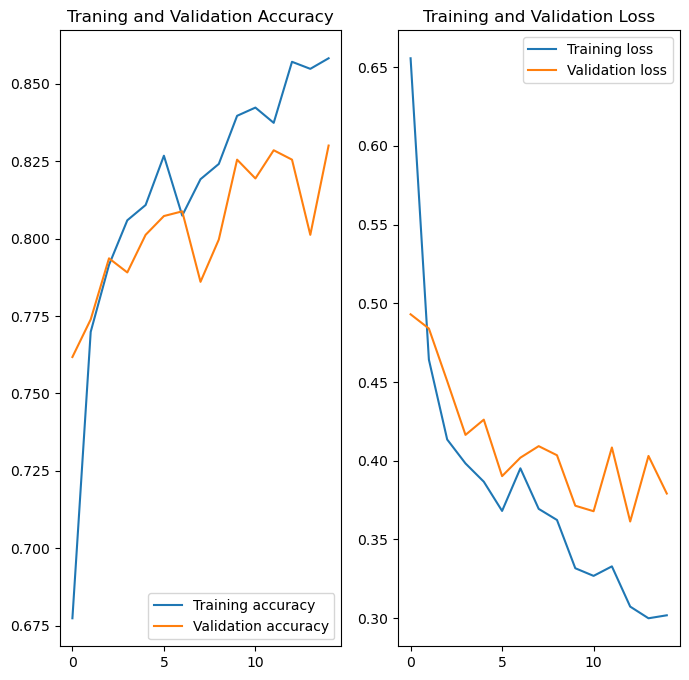

In [23]:
# Visualizing the training results

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Traning and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [24]:
# predict on new data
img = tf.keras.utils.load_img(
    "skin-cancer-data/bening1.jpg", target_size= (img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 298ms/step
This image most likely belongs to benign with a 99.99 percent confidence.


In [25]:
img2 = tf.keras.utils.load_img(
    "skin-cancer-data/malig.jpg", target_size = (img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
) 

1/1 [==============================] - 0s 49ms/step
This image most likely belongs to malignant with a 94.50 percent confidence.
